# Estimating tidal feature characterisitcs with CNN

## Motivation

The training data is from Subaru HSC. Images were extracted from a catalogue of visually classified tidal features of galaxies in a 200 deg2 section of the first public data release made by Erin Kado-Fong. This catalog can be found in the `Catalogues` directory. Each of the 21,000 targets is classified as either `Stream`, `Shell`, or `Non-detection`. The detections were boosted by an algorithm which highlights features with high spatial frequencies. In this project, I will use this catalogue as a training set for convolutional neural networks, `CNN`, which can then be used on the full survey.

## Getting started

### Dowloading the images

Downloading of the images is described on my `github` page: https://github.com/cbottrell/SubaruHSC_TidalCNN

The images are already normalized with a zeropoint of $m_{\mathrm{AB,zp}} = 27$ magnitudes. Because the WCS coordinate matrix is not the same for every patch of sky and the query tool only accepts image sizes in angular units (arcsec, for example), the number of pixels along each dimension of the images is not exact. Consequently, I downloaded images with a fixed angular size of $88.2$ arcsec. With the HSC CCD scale of $\sim0.168$ arcsec/pixel, this produces images with sizes roughly $525\times525$ which can then be cropped down to the desired $512\times512$ size.

### Estimating target sizes
Some sources do not have estimates of their sizes in the HSC data archive server. For these (or any) targets, I obtain the sizes using Sextractor (Bertin & Arnouts 1996) -- specifically, the version recently ported as the Python module, `sep` (Barbary 2016).

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os,sys
from glob import glob
from astropy.io import fits
from astropy.wcs import WCS
import sep


def Generate_Segmap(filename,galaxy_coordinates_wcs):
    '''
    Return a segmentation map where: (1) only the target galaxy is 
    included in the map and everything else is background; and (2)
    every object has a unique flag and the target is at the center
    of the colormap. Next returns are (3) the flagID of the 
    primary galaxy, (4) median background estimate (sky only),
    (5) rms estimate of background (sky pixels), (6) a catalog of
    all object properties.
    '''
    # Primary HDU for file
    hdulist = fits.open(filename)
    # obtain wcs info
    w = WCS(hdulist[1].header, hdulist)
    # image data
    image = hdulist[1].data.astype(float)
    # close Primary HDU
    hdulist.close()
    # filter kernel
    filter_kernel = np.loadtxt('/home/bottrell/utils/sdss-cfg/gauss_3.0_7x7.conv',skiprows=2)
    # use std of full image as detection threshold
    guess_rms = np.std(image)
    # mask all sources above std for background statistics
    mask = (image>guess_rms)
    # bkg object which includes sky() and rms() methods
    bkg = sep.Background(image, mask=mask, bw=32, bh=32, fw=3, fh=3)
    # run sep.extract() on image
    objCat,sexseg = sep.extract(image, thresh=1.0, err=bkg.rms(), mask=None, minarea=5,
                             filter_kernel=filter_kernel,filter_type='conv',deblend_nthresh=32,
                             deblend_cont=0.001, clean=True,clean_param=1.0, segmentation_map=True)
    # median background
    bkg_med = np.median(image[sexseg==0])
    # background noise
    bkg_rms = np.std(image[sexseg==0])
    # determine galaxy position in pixels (origin 0 for python indexing)
    galaxy_coordinates_pixels = tuple(w.wcs_world2pix([galaxy_coordinates_wcs],0).astype(int)[0][::-1])
    # identify flag for target galaxy in segmentation map
    pflag = sexseg[galaxy_coordinates_pixels]
    # galaxy segmentation map (only these pixels are used in the model)
    galseg = sexseg==pflag
    return galseg,sexseg,pflag,bkg_med,bkg_rms,objCat

catName = '/home/bottrell/scratch/Subaru/HyperSuprime/Catalogues/HSC-TF_all_2019-07-16_size_estimates.txt'
catData = np.loadtxt(catName,delimiter=',',dtype='str')[6254:6255,:]

objIDs = catData[:,0].astype(int)
ras = catData[:,2].astype(float)
decs = catData[:,3].astype(float)

# filterIDs = ['g','r','i','z','y']
filterIDs = ['i',]

for objID,ra,dec in zip(objIDs,ras,decs):
    for filterID in filterIDs:
        # filename
        fileName = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/{}_Cutout-525x525_{}.fits'.format(objID,filterID)
        print(fileName)
        # continue if image does not exist
        if not os.access(fileName,0):continue
        
        galaxy_coordinates_wcs = (ra,dec)
        galseg,sexseg,pflag,bkg_med,bkg_rms,objCat = Generate_Segmap(fileName,galaxy_coordinates_wcs)
        
        area_pixels = objCat[pflag-1][1]
        req = int(np.ceil(np.sqrt(float(area_pixels/np.pi))))
        print('R_SEx_{}: {}'.format(filterID,'%.3f'%(req*0.168)))


/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/1237665355622908267_Cutout-525x525_i.fits
R_SEx_i: 4.536


### Plot `sep` example

Here I plot the image and segmentation map for last galaxy processed above to show that the masking is behaving properly. The dark blue at the center corresponds to pixels that have been allocated to the target galaxy.

/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


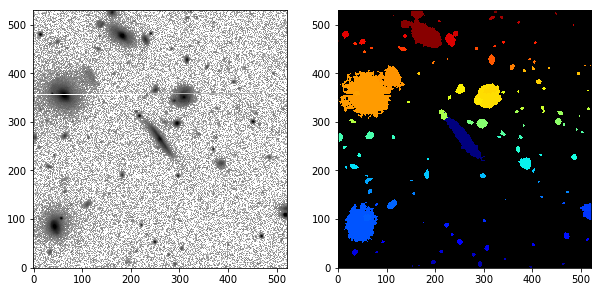

In [17]:
fig,axarr = plt.subplots(1,2,figsize=(10,5))
iData = np.log10(fits.getdata(fileName,0))
axarr[0].imshow(iData,vmin=-3,vmax=np.nanmax(iData[sexseg==pflag]),cmap='Greys',origin='lower')
cmap = cm.jet
cmap.set_bad('black',1.)
# total number of unique flags
rflags = np.unique(sexseg).astype(int)
# reorder from 0 to N (only strictly necessary if this is a cutout of a larger map)
nflags = np.arange(rflags.shape[0])
# reorder values so that pflag is in the middle of the color spectrum
a,b = rflags==pflag,int(np.floor(rflags.shape[0]/2))
rflags[a],rflags[b] = rflags[b],rflags[a]
segmap = np.zeros(sexseg.shape)
for rflag,nflag in zip(rflags,nflags):
    if rflag!=0:
        segmap[sexseg==rflag]=nflag
    else:
        segmap[sexseg==rflag]=np.nan
segmap[galseg] = 0
axarr[1].imshow(segmap,cmap=cmap,origin='lower',vmin = np.nanmin(segmap),vmax = np.nanmax(segmap))
        

### Fixed crop size cutouts
Here I use a fixed cutout size with respect to the downloaded images from the catalogues. The cutout size is defined by the `oShape` parameter. The images are then rebinned down (always, in this case) to the desired resized shape, `rShape`, which is the input shape for the CNN. 

/home/bottrell/scratch/Subaru/HyperSuprime/Input/45523550_Cutout-525x525_i.fits


/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in log10
/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in log10


/home/bottrell/scratch/Subaru/HyperSuprime/Input/135559904_Cutout-525x525_i.fits
/home/bottrell/scratch/Subaru/HyperSuprime/Input/1237659161736381021_Cutout-525x525_i.fits


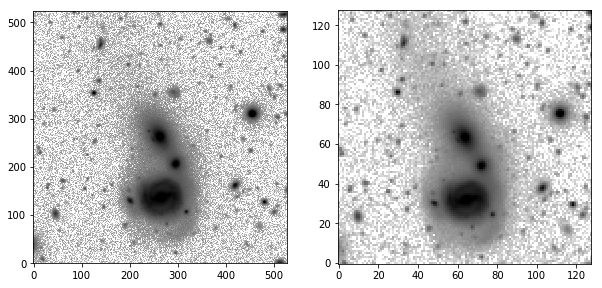

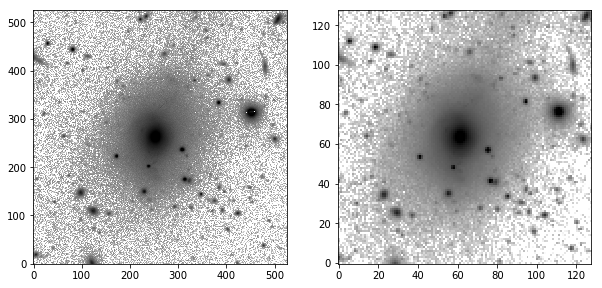

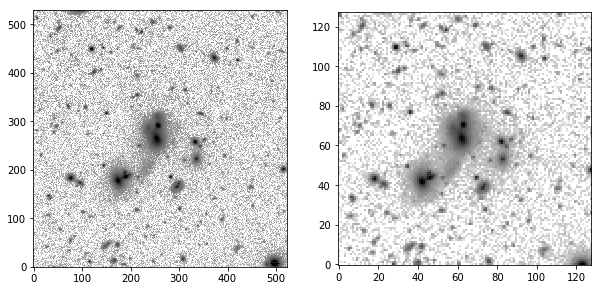

In [3]:
#!/usr/bin/env python

from astropy.io import fits
import numpy as np
import os,sys,glob
import matplotlib.pyplot as plt
from rebin import rebin
from scipy import interpolate

# catalogue name
catName = '../Catalogues/HSC-TF_all_2019-07-16_size_estimates.txt'
catData = np.loadtxt(catName,delimiter=',',dtype='str')[:3]
# directory in which all of the downloaded HSC images are stored
idir = '/home/bottrell/scratch/Subaru/HyperSuprime/Input/'
odir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Resized/'

arcsec_per_pixel = 0.168
oShape = (512,512) # crop shape
rShape = (128,128) # rebin shape
oRows,oCols = oShape[0],oShape[1]

objIDs = catData[:,0].astype(int)
ras = catData[:,2].astype(float)
decs = catData[:,3].astype(float)
# use r-band sizes to set scale
# sizes = catData[:,7].astype(float)/arcsec_per_pixel # pixels

# filterIDs = ['g','r','i','z','y']
filterIDs = ['i']

for objID,ra,dec in zip(objIDs,ras,decs):
    
    for filterID in filterIDs:
        
        # input filenames
        fileName = '{}{}_Cutout-525x525_{}.fits'.format(idir,objID,filterID)
        # output filenames
        outName = fileName.replace(idir,odir).replace('525x525','Resized')
        
        print(fileName)
        # check to see if input exists or output is already there
        # skip if either is true
        # if (not os.access(fileName,0)) or os.access(outName,0): continue
            
        iData = fits.getdata(fileName)
        iShape = iData.shape
        # difference in rows and columns from desired shape
        dRows,dCols = iShape[0]-oRows,iShape[1]-oCols
        hRows,hCols = int(dRows/2),int(dCols/2)
        
        if dRows%2==0: # take equal number of rows from bottom and top
            oData = iData[hRows:-hRows,:]
        else: # take 1 more pixel from the top always
            oData = iData[hRows+1:-hRows,:]
            
        if dCols%2==0: # take equal number of rows from left and right
            oData = oData[:,hCols:-hCols]
        else: # take 1 more pixel from the left always
            oData = oData[:,hCols:-(hCols+1)]
            
        oShape = oData.shape
        oHdr = fits.getheader(fileName,1)
        
        # use rebin tool if new shape is smaller than input
        if rShape[0]<oShape[0]:
            oData = rebin(oData,rShape)*float(rShape[0]*rShape[1]/oShape[0]/oShape[1])
        # use interp2d if new shape is smaller than input
        if rShape[0]>oShape[0]:
            x = np.linspace(0,1,oShape[0])
            y = np.linspace(0,1,oShape[1])
            f = interpolate.interp2d(x, y, oData, kind='linear')
            xn = np.linspace(0,1,rShape[0])
            yn = np.linspace(0,1,rShape[1])
            oData = f(xn,yn)

        oHdr['NAXIS1']=rShape[1]
        oHdr['NAXIS2']=rShape[0]
        
        fig,axarr = plt.subplots(1,2,figsize=(10,5))
        axarr[0].imshow(np.log10(iData),vmin=-3,vmax=1,cmap='Greys',origin='lower')
        axarr[1].imshow(np.log10(oData),vmin=-3,vmax=1,cmap='Greys',origin='lower')
#         fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/Interp_Demo.pdf',bbox_inches='tight')
#         fits.writeto(outName,data=oData,header=oHdr)
        
        

### Cutout sizes scaled by `r_det`

Here I check whether a certain scale factor applied to the sizes from the `HSC-TF_all_2019-07-16_size_estimates.txt` catalogue is appropriately big/small such that the streams/shells are still visible but the image is small enough so that it does not include more sources.

5.560652764763616
4.4470595681335565


/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in log10
/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in log10


5.560652764763616
5.228106229304237


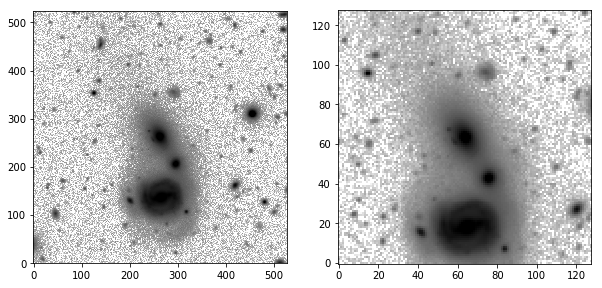

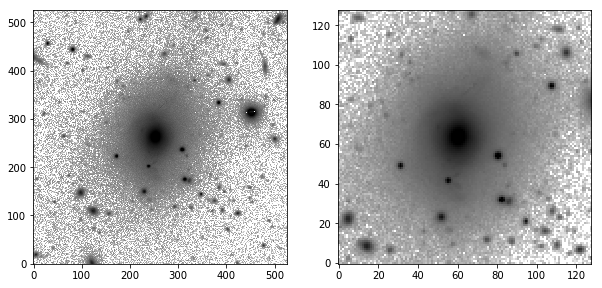

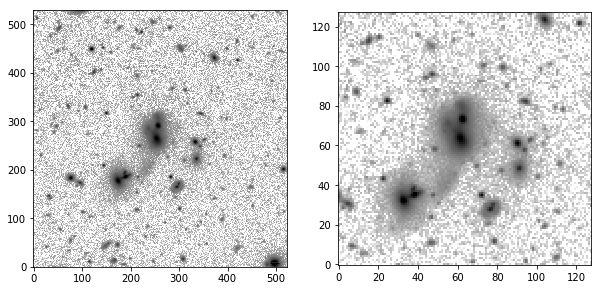

In [5]:
from astropy.io import fits
import numpy as np
import os,sys,glob
import matplotlib.pyplot as plt
from rebin import rebin
from scipy import interpolate

# catalogue name
catName = '../Catalogues/HSC-TF_all_2019-07-16_size_estimates.txt'
catData = np.loadtxt(catName,delimiter=',',dtype='str')[:3]
# directory in which all of the downloaded HSC images are stored
idir = '/home/bottrell/scratch/Subaru/HyperSuprime/Input/'
odir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/'

arcsec_per_pixel = 0.168
oShape = (512,512) # crop shape
rShape = (128,128) # rebin shape
oRows,oCols = oShape[0],oShape[1]

objIDs = catData[:,0].astype(int)
ras = catData[:,2].astype(float)
decs = catData[:,3].astype(float)
# use r-band sizes to set scale
sizes = catData[:,7].astype(float)/arcsec_per_pixel # pixels
#print(np.max(sizes))
# filterIDs = ['g','r','i','z','y']
filterIDs = ['i']

for objID,ra,dec,size in zip(objIDs,ras,decs,sizes):
    
    for filterID in filterIDs:
        
        # input filenames
        fileName = '{}{}_Cutout-525x525_{}.fits'.format(idir,objID,filterID)
        # output filenames
        outName = fileName.replace(idir,odir).replace('525x525','Resized')
        
        # check to see if input exists or output is already there
        # skip if either is true
        if (not os.access(fileName,0)) or os.access(outName,0): continue
            
        iData = fits.getdata(fileName)
        iShape = iData.shape
        
        print(size)
        testSize = int(np.ceil(size*80))
        if testSize > oShape[0] or testSize > oShape[1]:
            oRows,oCols = oShape[0],oShape[1]
        else:
            oRows = oCols = testSize
        oShape = (oRows,oCols)
        
        # difference in rows and columns from desired shape
        dRows,dCols = iShape[0]-oRows,iShape[1]-oCols
        hRows,hCols = int(dRows/2),int(dCols/2)
        
        if dRows%2==0: # take equal number of rows from bottom and top
            oData = iData[hRows:-hRows,:]
        else: # take 1 more pixel from the top always
            oData = iData[hRows+1:-hRows,:]
            
        if dCols%2==0: # take equal number of rows from left and right
            oData = oData[:,hCols:-hCols]
        else: # take 1 more pixel from the left always
            oData = oData[:,hCols:-(hCols+1)]
            
        oShape = oData.shape
        oHdr = fits.getheader(fileName,1)
        
        # use rebin tool if new shape is smaller than input
        if rShape[0]<oShape[0]:
            oData = rebin(oData,rShape)*float(rShape[0]*rShape[1]/oShape[0]/oShape[1])
        # use interp2d if new shape is smaller than input
        if rShape[0]>oShape[0]:
            x = np.linspace(0,1,oShape[0])
            y = np.linspace(0,1,oShape[1])
            f = interpolate.interp2d(x, y, oData, kind='linear')
            xn = np.linspace(0,1,rShape[0])
            yn = np.linspace(0,1,rShape[1])
            oData = f(xn,yn)

        oHdr['NAXIS1']=rShape[1]
        oHdr['NAXIS2']=rShape[0]
        
        fig,axarr = plt.subplots(1,2,figsize=(10,5))
        axarr[0].imshow(np.log10(iData),vmin=-3,vmax=1,cmap='Greys',origin='lower')
        axarr[1].imshow(np.log10(oData),vmin=-3,vmax=1,cmap='Greys',origin='lower')
        
        

### Cropping and resizing the images

First, the image is cropped so that it focuses on the main target. This cropping should be based on some scaling of the target galaxy's size -- but one should recall that there are tidal features in the images which extend beyond the target galaxy's main profile. Once the image is cropped, it is rebinned to a consistent size that is fixed for all images.

/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in log10
/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in log10


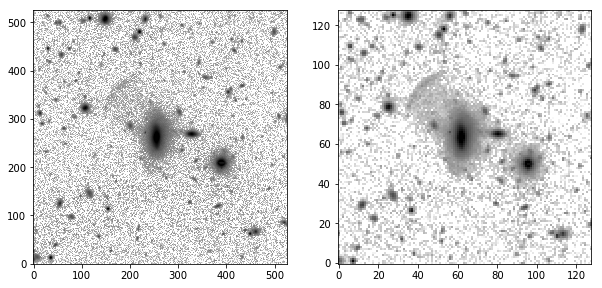

In [12]:
from astropy.io import fits
import numpy as np
import os,sys,glob
import matplotlib.pyplot as plt
from rebin import rebin
from scipy import interpolate

# directory in which all of the downloaded HSC images are stored
idir = '/home/bottrell/scratch/Subaru/HyperSuprime/Input/'
odir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/'

# filename placeholders
_fileList_ = sorted(list(glob.glob('{}*525x525_i.fits'.format(idir))))[:1]
_fileList_ = [fileName.replace('_i.fits','_{}.fits') for fileName in _fileList_]

# square shape to which the image is cropped
oShape = (512,512)
# shape to which the cropped image is rebinned (all final images should be this size)
rShape = (128,128)

oRows,oCols = oShape[0],oShape[1]

# filters in which to perform operations (if files exist)
# filterIDs = ['g','r','i','z','y']
filterIDs = ['i']

for _fileName_ in _fileList_:
    
    for filterID in filterIDs:
        
        # input filenames
        fileName = _fileName_.format(filterID)
        # output filenames
        outName = fileName.replace(idir,odir).replace('525x525','Resized')
        
        # check to see if input exists or output is already there
        # skip if either is true
        if (not os.access(fileName,0)) or os.access(outName,0): continue
            
        iData = fits.getdata(fileName)
        iShape = iData.shape
        # difference in rows and columns from desired shape
        dRows,dCols = iShape[0]-oRows,iShape[1]-oCols
        hRows,hCols = int(dRows/2),int(dCols/2)
        
        if dRows%2==0: # take equal number of rows from bottom and top
            oData = iData[hRows:-hRows,:]
        else: # take 1 more pixel from the top always
            oData = iData[hRows+1:-hRows,:]
            
        if dCols%2==0: # take equal number of rows from left and right
            oData = oData[:,hCols:-hCols]
        else: # take 1 more pixel from the left always
            oData = oData[:,hCols:-(hCols+1)]
            
        oShape = oData.shape
        oHdr = fits.getheader(fileName,1)
        
        # use rebin tool if new shape is smaller than input
        if rShape[0]<oShape[0]:
            oData = rebin(oData,rShape)*float(rShape[0]*rShape[1]/oShape[0]/oShape[1])
        # use interp2d if new shape is smaller than input
        if rShape[0]>oShape[0]:
            x = np.linspace(0,1,oShape[0])
            y = np.linspace(0,1,oShape[1])
            f = interpolate.interp2d(x, y, oData, kind='linear')
            xn = np.linspace(0,1,rShape[0])
            yn = np.linspace(0,1,rShape[1])
            oData = f(xn,yn)

        oHdr['NAXIS1']=rShape[1]
        oHdr['NAXIS2']=rShape[0]
        
        fig,axarr = plt.subplots(1,2,figsize=(10,5))
        axarr[0].imshow(np.log10(iData),vmin=-3,vmax=1,cmap='Greys',origin='lower')
        axarr[1].imshow(np.log10(oData),vmin=-3,vmax=1,cmap='Greys',origin='lower')
        #fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/Interp_Demo.pdf',bbox_inches='tight')
        #fits.writeto(outName,data=oData,header=oHdr)
        


### Multiprocessing tests

Here I am comparing the speed of processing the cutouts using `multiprocessing` compared to an ordinary `for` loop on a Beluga node. This code was eventually used to rebin all of the cutouts from the catalogue.

In [3]:
#!/usr/bin/env python

from astropy.io import fits
import numpy as np
import os,sys,glob
from rebin import rebin
from scipy import interpolate
import multiprocessing,time

# enviornment properties
SLURM_CPUS = int(os.environ['SLURM_JOB_CPUS_PER_NODE'])

# catalogue name
catName = '/home/bottrell/scratch/Subaru/HyperSuprime/Catalogues/HSC-TF_all_2019-07-16_size_estimates.txt'
catData = np.loadtxt(catName,delimiter=',',dtype='str')
# directory in which all of the downloaded HSC images are stored
idir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/'
odir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Resized/'

arcsec_per_pixel = 0.168
oShape = (512,512) # crop shape
rShape = (128,128) # rebin shape

objIDs = catData[:,0].astype(int)
ras = catData[:,2].astype(float)
decs = catData[:,3].astype(float)
# use r-band sizes to set scale
# sizes = catData[:,7].astype(float)/arcsec_per_pixel # pixels

# filterIDs = ['g','r','i','z','y']
filterIDs = ['i']
        
def Resize_Cutout(arg):
    fileName,outName,oShape,rShape = arg

    oRows,oCols = oShape[0],oShape[1]
    iData = fits.getdata(fileName)
    iShape = iData.shape
    # difference in rows and columns from desired shape
    dRows,dCols = iShape[0]-oRows,iShape[1]-oCols
    hRows,hCols = int(dRows/2),int(dCols/2)

    if dRows%2==0: # take equal number of rows from bottom and top
        oData = iData[hRows:-hRows,:]
    else: # take 1 more pixel from the top always
        oData = iData[hRows+1:-hRows,:]

    if dCols%2==0: # take equal number of rows from left and right
        oData = oData[:,hCols:-hCols]
    else: # take 1 more pixel from the left always
        oData = oData[:,hCols:-(hCols+1)]

    oShape = oData.shape
    oHdr = fits.getheader(fileName,1)
    # use rebin tool if new shape is smaller than input
    if rShape[0]<oShape[0]:
        oData = rebin(oData,rShape)*float(rShape[0]*rShape[1]/oShape[0]/oShape[1])
    # use interp2d if new shape is smaller than input
    if rShape[0]>oShape[0]:
        x = np.linspace(0,1,oShape[0])
        y = np.linspace(0,1,oShape[1])
        f = interpolate.interp2d(x, y, oData, kind='linear')
        xn = np.linspace(0,1,rShape[0])
        yn = np.linspace(0,1,rShape[1])
        oData = f(xn,yn)
    oHdr['NAXIS1']=rShape[1]
    oHdr['NAXIS2']=rShape[0]
    fits.writeto(outName,data=oData,header=oHdr)

# list of filenames, output names, crop shapes and final shapes
args = [ ('{}{}_Cutout-525x525_{}.fits'.format(idir,objID,filterID),'{}{}_Cutout-Resized_{}.fits'.format(odir,objID,filterID),oShape,rShape) for objID,ra,dec in zip(objIDs,ras,decs) for filterID in filterIDs ]

argList = []
for arg in args:
    if os.access(arg[0],0) and not os.access(arg[1],0):
        argList.append(arg)
argList = list(set(argList))

if __name__ == '__main__':
    pool = multiprocessing.Pool(SLURM_CPUS)
    pool.map_async(Resize_Cutout, argList)
    pool.close()
    pool.join()

### Compute `SExtractor` sizes for all galaxies in catalog

The `r_det` values seem to be often erroneous. I try to get around this by computing `SExtractor` sizes for each galaxy in each band. This is performed for all galaxies in all bands uisng the `SExtractor_Sizes.py` file.

In [ ]:
#!/usr/bin/env python

# Compute SExtractor sizes and create new catalogue

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os,sys,datetime,time
from glob import glob
from astropy.io import fits
from astropy.wcs import WCS
import sep
now = datetime.datetime.now()
author = 'Connor Bottrell'

def Generate_Segmap(filename,galaxy_coordinates_wcs):
    '''
    Return a segmentation map where: (1) only the target galaxy is 
    included in the map and everything else is background; and (2)
    every object has a unique flag and the target is at the center
    of the colormap. Next returns are (3) the flagID of the 
    primary galaxy, (4) median background estimate (sky only),
    (5) rms estimate of background (sky pixels), (6) a catalog of
    all object properties.
    '''
    # Primary HDU for file
    hdulist = fits.open(filename)
    # obtain wcs info
    w = WCS(hdulist[1].header, hdulist)
    # image data
    image = hdulist[1].data.astype(float)
    # close Primary HDU
    hdulist.close()
    # filter kernel
    filter_kernel = np.loadtxt('/home/bottrell/utils/sdss-cfg/gauss_3.0_7x7.conv',skiprows=2)
    # use std of full image as detection threshold
    guess_rms = np.std(image)
    # mask all sources above std for background statistics
    mask = (image>guess_rms)
    # bkg object which includes sky() and rms() methods
    bkg = sep.Background(image, mask=mask, bw=32, bh=32, fw=3, fh=3)
    # run sep.extract() on image
    objCat,sexseg = sep.extract(image, thresh=1.0, err=bkg.rms(), mask=None, minarea=5,
                             filter_kernel=filter_kernel,filter_type='conv',deblend_nthresh=32,
                             deblend_cont=0.001, clean=True,clean_param=1.0, segmentation_map=True)
    # median background
    bkg_med = np.median(image[sexseg==0])
    # background noise
    bkg_rms = np.std(image[sexseg==0])
    # determine galaxy position in pixels (origin 0 for python indexing)
    galaxy_coordinates_pixels = tuple(w.wcs_world2pix([galaxy_coordinates_wcs],0).astype(int)[0][::-1])
    # identify flag for target galaxy in segmentation map
    pflag = sexseg[galaxy_coordinates_pixels]
    # galaxy segmentation map (only these pixels are used in the model)
    galseg = sexseg==pflag
    return galseg,sexseg,pflag,bkg_med,bkg_rms,objCat

catName = '/home/bottrell/scratch/Subaru/HyperSuprime/Catalogues/HSC-TF_all_2019-07-16_size_estimates.txt'
catData = np.loadtxt(catName,delimiter=',',dtype='str')

# objIDs = catData[:,0].astype(int)
# ras = catData[:,2].astype(float)
# decs = catData[:,3].astype(float)

# Subaru HSC pixel scale
arcsec_per_pixel = 0.168

# priority ordering of filterIDs
filterIDs = ['g','r','i','z','y']

with open(catName,'r') as f:
    lines = f.readlines()
    
newCat = '/home/bottrell/scratch/Subaru/HyperSuprime/Catalogues/HSC-TF_all_2019-07-25.txt'

# if os.access(newCat,0):os.remove(newCat) #!!! Remove after testing
    
if not os.access(newCat,0):
    with open(newCat,'w') as f:
        f.write('#'*50+'\n')
        f.write('# File initialized: {}\n'.format(datetime.datetime.now()))
        f.write('# By: {}\n'.format(author))
        f.write('#'*50+'\n')
        header = lines[0].split('\n')[0].split(',')
        header = header + ['req_sex_{}'.format(filterID) for filterID in filterIDs]
        header[0] = 'objectID_Cat'
        for ii,entry in enumerate(header):
            f.write('# [{}] {}\n'.format(ii,entry))
        f.write('#'*50+'\n')
    objIDs_Done = np.array([])
else:
    objIDs_Done = np.loadtxt(newCat,delimiter=',',dtype='str')[:,0].astype(int)


imgDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/'

for line in lines[1:]:

    line = line.split('\n')[0]
    objID,z,ra,dec=line.split(',')[:4]
    objID = int(objID)
    if objID in objIDs_Done: continue
    z = float(z)
    ra = float(ra)
    dec = float(dec)
    
    req_arcsec = np.zeros(len(filterIDs))
    
    for i,filterID in enumerate(filterIDs):
        # filename
        fileName = '{}{}_Cutout-525x525_{}.fits'.format(imgDir,objID,filterID)
        # continue if image does not exist
        if not os.access(fileName,0):
            req_arcsec[i] = -1
            continue
        galaxy_coordinates_wcs = (ra,dec)

        try:
            galseg,sexseg,pflag,bkg_med,bkg_rms,objCat = Generate_Segmap(fileName,galaxy_coordinates_wcs)
            area_pixels = objCat[pflag-1][1]
            req_pixel = np.sqrt(float(area_pixels)/np.pi)
            req_arcsec[i] = req_pixel*arcsec_per_pixel
        except:
            req_arcsec[i] = -999

    newLine = ','.join(['%0.3f'%req_arcsec[i] for i in range(len(filterIDs))])
    print(fileName,newLine)
#     with open(newCat,'a') as f:
#         f.write('{},{}\n'.format(line,newLine))

/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/1237660024493572454_Cutout-525x525_y.fits 0.683,7.996,3.646,3.142,2.840
/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/1237679338959667319_Cutout-525x525_y.fits 8.949,11.160,10.043,9.151,6.992
/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/1237663480335958649_Cutout-525x525_y.fits 2.955,4.236,5.306,-999.000,3.926
/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/1237678881547026839_Cutout-525x525_y.fits 10.377,12.500,10.563,8.638,7.853
/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/1237678879959745127_Cutout-525x525_y.fits 2.223,3.232,3.446,3.067,2.651
/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/1237679255205904514_Cutout-525x525_y.fits 5.792,7.052,8.003,6.711,6.149


### Convert indivisual files into large npz files for binary classifications

Generate pre-normalization and pre-augmentation images and associated objID catalogues corresponding to each index. Must have a catch in case the target image does not exist. The main reason that a target image does not exist is that it is unavailable on the HSC data archive server. Now in python script called `Generate_BinaryInput.py`. The output image files and catalogues are in the `/Data/Binary/` directory.


In [1]:
#!/usr/bin/env python

import os,sys,time
import multiprocessing
import numpy as np
from glob import glob
from astropy.io import fits

def Generate_Files(args):
    
    fileName,catName,imgDir,classID,filterIDs = args

    if os.access(fileName,0):
        print('File already exists: {}\nDelete files and try again.'.format(fileName))
        
    elif os.access(catName,0):
        print('File already exists: {}\nDelete files and try again.'.format(catName))
    
    else:
        print('Making files:\nData: {} \nCatalogue: {}'.format(fileName,catName))

        # catalogue of input objIDs and sizes (need the size flags to know whether to keep galaxy)
        inCat = '/home/bottrell/scratch/Subaru/HyperSuprime/Catalogues/HSC-TF_all_2019-07-25.txt'
        # filters to go into catalog
        filterIDs = ['g','r','i','z','y']
        # number of corresponding channels
        nChannels = len(filterIDs)
        # input catalogue data
        inCatData = np.loadtxt(inCat,delimiter=',',dtype='str')
        # morphID (stream/shell/non)
        morphIDs = inCatData[:,5]
        # objIDs from catalog
        objIDs = inCatData[:,0].astype(int)
        # image dimensions
        dx = dy = 128

        if classID == 'Positive':
            indices = morphIDs!='non'
        if classID == 'Negative':
            indices = morphIDs=='non'
        objIDs = objIDs[indices]
        morphIDs = morphIDs[indices]

        # initialize numpy array with shape: (len(objIDs),dx,dy,nChannels)
        outData = np.empty(shape=(len(objIDs),dx,dy,nChannels),dtype=float)
        # initialize output catalogue (objID,(stream/shell/non),g_exists,r_exists,i_exists,z_exists,y_exists)
        outCat = np.empty(shape=(len(objIDs),7),dtype='<U32')

        for ii,objID in enumerate(objIDs):
            outCat[ii,0] = objID
            outCat[ii,1] = morphIDs[ii]
            for jj,filterID in enumerate(filterIDs):
                imgName = '{}{}_Cutout-Resized_{}.fits'.format(imgDir,objID,filterID)
                if not os.access(imgName,0):
                    outData[ii,:,:,jj] = np.zeros((dx,dy))
                    outCat[ii,jj+2] = 0
                else:
                    outData[ii,:,:,jj] = fits.getdata(imgName)
                    outCat[ii,jj+2] = 1

        np.save(fileName,outData)
        np.save(catName,outCat)

if __name__ == "__main__":
    
    # enviornment properties
    SLURM_CPUS = int(os.environ['SLURM_JOB_CPUS_PER_NODE'])
    # class options
    classIDs = ['Positive','Negative']
    # filters to go into catalog
    filterIDs = ['g','r','i','z','y']
    # filter label for numpy array
    label = ''.join(filterIDs)
    # output filename holder
    _fileName_ = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/{}_{}_Images.npy'
    # output catalogue name holder
    _catName_ = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/{}_{}_Images_cat.npy'
    # input image directory
    imgDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Resized/'

    # pool tasks
    argList = [(_fileName_.format(classID,label),_catName_.format(classID,label),imgDir,classID,filterIDs) for classID in classIDs]
    pool = multiprocessing.Pool(SLURM_CPUS)
    pool.map(Generate_Files, argList)
    pool.close()
    pool.join()



Starting run.
File already exists: /home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/Positive_grizy_Images.npy
Delete files and try again.
File already exists: /home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/Negative_grizy_Images.npy
Delete files and try again.


### Visualizaiton of 100 stream/shell hosts
Here I plot 100 stream/shell hosts from the positive sample.




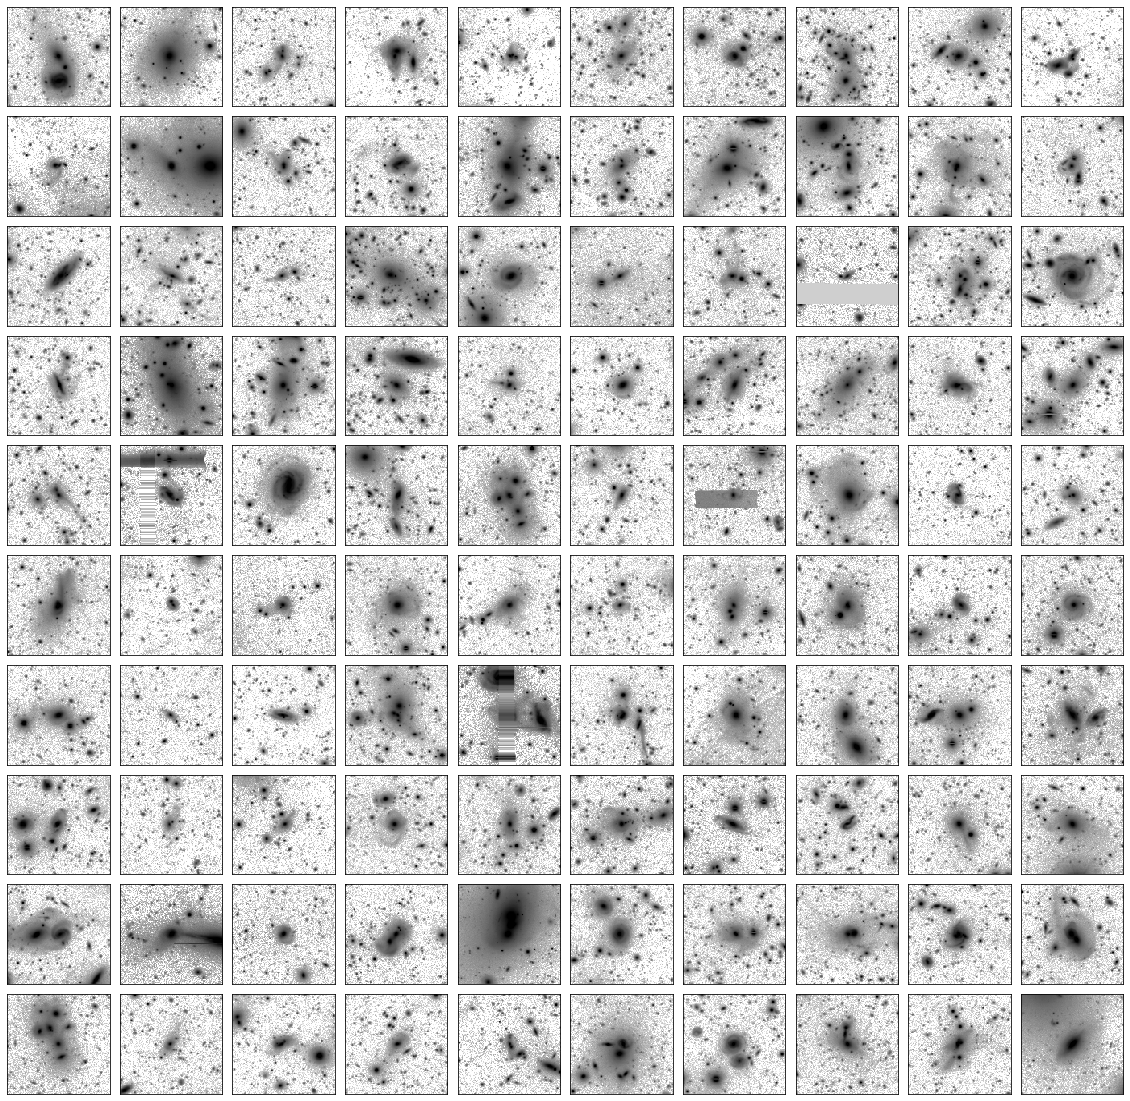

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

fileName = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/Positive_grizy_Images.npy'
data = np.load(fileName)[:100]
fig,axarr = plt.subplots(10,10,figsize=(20,20))
fig.subplots_adjust(hspace=0.1,wspace=0.1)
channel = 2 # i-band

for i,ax in zip(range(len(data)),axarr.flat):
    img = data[i,:,:,channel]
    ax.imshow(np.log10(img),origin='lower',cmap='Greys',vmin=-3,vmax=1,aspect='auto')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

### Reference catalogues

Reference catalogues tell me the objID, morphID, and whether a non-zero image exists for the target in the $grizy$ bands. Here I take the 46th element of the image list above (the first 100 in the full list), print its catalogue entry and plot its original image in the $z$ band (before reshaping) -- which is less affected by imaging artifacts than in the $i$-band image above.

Catagogue entry: ['1237655349969224462' 'stream' '1' '1' '1' '1' '1']


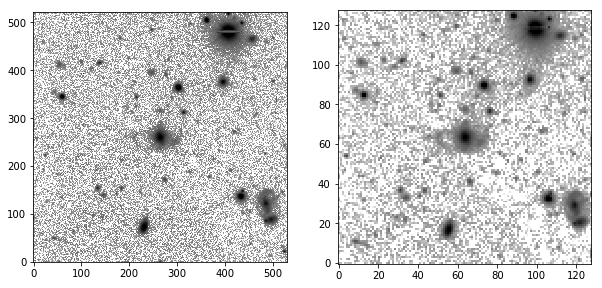

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

cat = np.load('/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/Positive_grizy_Images_cat.npy')
print('Catagogue entry: {}'.format(cat[46]))
objID = cat[46,0]
fig,axarr = plt.subplots(1,2,figsize=(10,5))

imgDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Images/'
fileName = '{}_Cutout-525x525_z.fits'.format(objID)
axarr[0].imshow(np.log10(fits.getdata(imgDir+fileName)),
          cmap='Greys',origin='lower',vmin=-3,vmax=1)

imgDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Resized/'
fileName = '{}_Cutout-Resized_z.fits'.format(objID)
axarr[1].imshow(np.log10(fits.getdata(imgDir+fileName)),
          cmap='Greys',origin='lower',vmin=-3,vmax=1)

### Data augmentation

Here I apply augmentation to the stream/shell data. The data are heavily unbalanced, with roughly 1:20 in favor of the non-detections. Therefore, I keep all of the non-detection data and augment each of the detection images.

In [3]:
#!/usr/bin/env python
import numpy as np
import os,sys,multiprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import scipy.ndimage
import random

if __name__ == '__main__':
    
    # enviornment properties
    SLURM_CPUS = int(os.environ['SLURM_JOB_CPUS_PER_NODE'])

    dataGen = ImageDataGenerator(   
            rotation_range=180,
            width_shift_range=0.05,
            height_shift_range=0.05,
            fill_mode='constant', # !!! talk about this
            cval=0.0,
            vertical_flip =True,
            zoom_range = 0.1,
            horizontal_flip =True,
            data_format= 'channels_last')
    
    minLen = 20000
    
    dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
    classID = 'Positive'
    inData = np.load('{}{}_grizy_Images.npy'.format(dataDir,classID))
    inCat = np.load('{}{}_grizy_Images_cat.npy'.format(dataDir,classID)).astype(str)
    iShape = inData.shape
    nChannels = iShape[-1]
    nRecords = iShape[0]
    dx = dy = iShape[1]
    
    # number of augmentations per image
    nAug = int(np.floor(minLen/nRecords))
    # output shape
    oShape = (nAug*nRecords,dx,dy,nChannels)
    # output data
    outData = np.empty(shape=oShape)
    # output catalogue
    outCat = np.empty(shape=(nAug*nRecords,inCat.shape[1]),dtype='S32')

    # output files
    outDataFile = '{}{}_grizy_Images-Aug.npy'.format(dataDir,classID)
    outCatFile = '{}{}_grizy_Images-Aug_cat.npy'.format(dataDir,classID)
    
    if os.access(outDataFile,0):
        print('File already exists: {}\nDelete files and try again.'.format(outDataFile))
        
    elif os.access(outCatFile,0):
        print('File already exists: {}\nDelete files and try again.'.format(outCatFile))
    
    else:
        argList = []
        # fill augmented data array
        for img_i in range(nRecords):
            for augm_i in range(nAug): 
                outData[img_i+augm_i*nRecords] = dataGen.flow(inData[img_i].reshape((1,dx,dy,nChannels)), batch_size=1)[0]
                outCat[img_i+augm_i*nRecords] = inCat[img_i]
        # save to output file
        np.save(outDataFile,np.concatenate([inData,outData],axis=0))
        np.save(outCatFile,np.concatenate([inCat,outCat],axis=0))

Using TensorFlow backend.
/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 128, 128, 5) (5 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


### Visualization of data augmentation

The first 2 augmentations (and the original) for a stream host in the catalogue. I show the $i$-band images.

(20417, 128, 128, 5)
-2555.591444015503


/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10
/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log10
/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log10


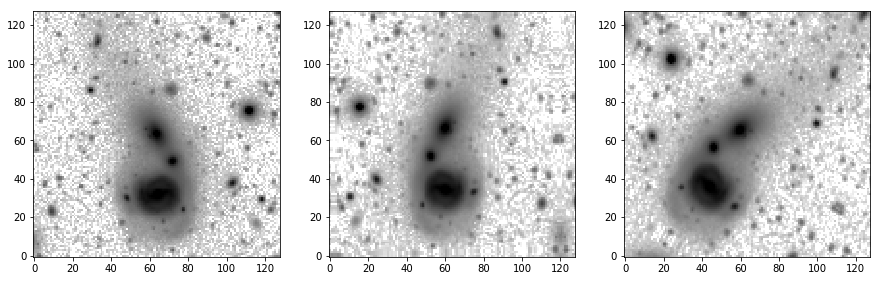

In [10]:
import matplotlib.pyplot as plt
import numpy as np

dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
classID = 'Positive'
channel = 2

# output data
outDataFile = '{}{}_grizy_Images-Aug.npy'.format(dataDir,classID)
# output catalogue
outCatFile = '{}{}_grizy_Images-Aug_cat.npy'.format(dataDir,classID)

outData = np.load(outDataFile)

print(outData.shape)


fig,axarr = plt.subplots(1,3,figsize=(15,5))

print(np.min(outData))
ax = axarr[0]
ax.imshow(np.log10(outData[0,:,:,channel]),vmin=-3,vmax=1,cmap='Greys',origin='lower')

ax = axarr[1]
ax.imshow(np.log10(outData[1201,:,:,channel]),vmin=-3,vmax=1,cmap='Greys',origin='lower')

ax = axarr[2]
ax.imshow(np.log10(outData[3603,:,:,channel]),vmin=-3,vmax=1,cmap='Greys',origin='lower')


### Normalize augmented data: log-scale

Normalize augmented image dataset using a logarithmic scale. Contrast can be optimized to focus on the central target or use a fixed uniform contrast for the whole survey. The latter may be better for looking at streams and shells since we do not care about the light from the main galaxy as much.

In [6]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
import os,sys,warnings
warnings.filterwarnings('ignore')
from astropy.visualization import make_lupton_rgb

def Normalize_LOG10(x,window=20,is_sky=False,keepColour=True):
    '''Normalize (multi-band) images uisng a logarithmic scaling while preserving colour information. Input should be in linear units and be of shape (nRecords,dx,dy,nChannels).'''
    nRecords,dx,dy,nChannels = x.shape
    # if sky noise is present, subtract sky level 
    if is_sky:
        x = x - np.nanmedian(x,axis=(1,2)).reshape(-1,1,1,nChannels)
    # take log of skyless image
    x = np.log10(x)
    # get rid of pesky nan values
    x[x<-5]=np.nan
    # image centre
    xc = yc = int(dx/2)
    # window dimensions
    dwinx = dwiny = int(window/2)
    # minimum value to be considered
    a_min = -3
    if keepColour:
        for i in range(nRecords):
            imgCube = x[i]
            a_max = np.nanpercentile(imgCube[xc-dwinx:xc+dwinx,yc-dwiny:yc+dwiny,:],99,
                                     axis=(0,1)).reshape(1,1,nChannels)
            a_max = np.max(a_max)
            imgCube = np.clip(imgCube,a_min=a_min,a_max=a_max)
            imgCube[np.isnan(imgCube)]=a_min
            imgCube = (imgCube - a_min)/(a_max-a_min)
            x[i] = imgCube
    else:
        for i in range(nRecords):
            imgCube = x[i]
            a_max = np.nanpercentile(imgCube[xc-dwinx:xc+dwinx,yc-dwiny:yc+dwiny,:],99,
                                     axis=(0,1))
            for j in range(nChannels):
                img = imgCube[:,:,j]
                img = np.clip(img,a_min=a_min,a_max=a_max[j])
                img[np.isnan(img)]=a_min
                img = (img - a_min)/(a_max[j]-a_min)
                x[i,:,:,j] = img
    return x

def Normalize_Constant(x,vmin=-3,vmax=1,is_sky=False,keepColour=True):
    '''Normalize (multi-band) images uisng a fixed scaling on a logarithmic scale -- preserving colour information.'''
    nRecords,dx,dy,nChannels = x.shape
    # if sky noise is present, subtract sky level 
    if is_sky:
        x = x - np.nanmedian(x,axis=(1,2)).reshape(-1,1,1,nChannels)
    # take log of skyless image
    x = np.log10(x)
    if keepColour:
        x[np.isnan(x)] = vmin
        x[x<vmin] = vmin
        x[x>vmax] = vmax
        x = (x - vmin)/(vmax-vmin)
    return x
    
    

if __name__ == '__main__':
    
    classIDs = ['Positive','Negative']
    dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
    
    for classID in classIDs:
        if classID == 'Positive':
            DataFile = '{}{}_grizy_Images-Aug.npy'.format(dataDir,classID)
            outFile = DataFile.replace('Aug','AugNorm')
        if classID == 'Negative':  
            DataFile = '{}{}_grizy_Images.npy'.format(dataDir,classID)
            outFile = DataFile.replace('.npy','-AugNorm.npy')
        if os.access(outFile,0):
            print('File already exists: {}\nDelete files and try again.'.format(outFile))
            continue

        x = np.load(DataFile)
        nRecords,dx,dy,nChannels = x.shape

        # Normalization options

        # x = Normalize_LOG10(x,window=20,is_sky=False,keepColour=True)
        x = Normalize_LOG10(x,window=20,is_sky=False,keepColour=False)
        # x = Normalize_Constant(x,vmin=-3,vmax=1,is_sky=False,keepColour=True)

        # save normalized data to file
        np.save(outFile,x)



File already exists: /home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/Positive_grizy_Images-AugNorm.npy
Delete files and try again.


## Network architecture

### Traditional CNN

In [ ]:
import os,sys,json
import keras
from keras import backend as K
from keras.models import Model,load_model
from keras.layers import Input,Dense,Dropout,Flatten
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
import numpy as np

def save_model_history(model,history_filename):
    with open(history_filename,'w') as f:
        json.dump(model.history.history, f)

classIDs = ['Negative','Positive']
nClasses = len(classIDs)
dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
fileNames = ['{}{}_grizy_Images-AugNorm.npy'.format(dataDir,classID) for classID in classIDs]

# # create target array
# tar = np.array([])
# for ii,fileName in enumerate(fileNames):
#     tar = np.append(tar,np.ones(np.load(fileName).shape[0])*ii)
# tar = tar.astype(int)
# # create input array 
# inp = np.concatenate([np.load(fileName) for fileName in fileNames],axis=0)



nRecords,dx,dy,nChannels = inp.shape

nRecords,dx,dy,nChannels = (40000,128,128,5)

# convolution model
inputs = Input(shape=(dx,dy,nChannels), name='main_input')

# first conv layer
x = Conv2D(32, kernel_size=(6,6),activation='relu',
           padding='same',strides=(1, 1),name='Conv_1')(inputs)
x = MaxPooling2D(pool_size=(2,2),name='MP_C1')(x)
#x = Dropout(0.25,name='Drop_C1')(x)

# second conv layer
x = Conv2D(64, kernel_size=(5,5),activation='relu',
           padding='same',strides=(1, 1),name='Conv_2')(x)
x = MaxPooling2D(pool_size=(2,2),name='MP_C2')(x)
#x = Dropout(0.25,name='Drop_C2')(x)

# third conv layer
x = Conv2D(128, kernel_size=(2,2),activation='relu',
           padding='same',strides=(1, 1),name='Conv_3')(x)
x = MaxPooling2D(pool_size=(2,2),name='MP_C3')(x)
#x = Dropout(0.25,name='Drop_C3')(x)

# fourth conv layer
x = Conv2D(128, kernel_size=(3,3),activation='relu',
           padding='same',strides=(1, 1),name='Conv_4')(x)
# x = Dropout(0.25,name='Drop_C4')(x)

# flatten for fully connected layers
x = Flatten(name='Flatten')(x)

# Fully Connected Layer
x = Dense(64,activation='relu',name='Dense_1')(x)
x = Dropout(0.5,name='DropFCL_1')(x)
x = Dense(16,activation='relu',name='Dense_2')(x)
x = Dropout(0.5,name='DropFCL_2')(x)
x = Dense(nClasses,activation=None,name='Dense_3')(x) 
x = keras.layers.Activation('softmax')(x)

model = Model(inputs=inputs,outputs=x)


model.compile(optimizer=keras.optimizers.Adadelta(), 
              loss='categorical_crossentropy',metrics=['accuracy'])

plot_model(model)
# # host directory
# datadir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
# modeldir = '/home/bottrell/scratch/RealCNN/MultiClass/Models/'
# # careful of ordering here
# tags = ['Iso','Pair','Post']
# # data type from which to generate model 
# # options are:
# # 'StellarMap','StellarMap_SemiReal','StellarMap_FullReal'
# # 'Photometry','Photometry_semiReal','Photometry_FullReal'
# labels = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
#           'Photometry','Photometry_semiReal','Photometry_FullReal']

# batch_size = 32
# epochs=30
# dx = 139
# dy = 139
# train_valid_split = 0.3
# valid_test_split = 0.5
# update = 0
# version = 0 
          
# for label in labels:

#     # number of channels
#     nChannels = (1 if 'StellarMap' in label else 3)

#     # data files
#     filenames = ['{}{}-{}-InpAugNorm.npy'.format(datadir,tag,label) for tag in tags]
#     # concatenate all data into one large object
#     inp = np.concatenate([np.load(filename) for filename in filenames],axis=0)
#     # create target array
#     tar = np.array([])
#     for ii,filename in enumerate(filenames):
#         tar = np.append(tar,np.ones(np.load(filename).shape[0])*ii)
#     tar = tar.astype(int)

#     # One-Hot fromatting
#     tar_OH= keras.utils.to_categorical(tar) 
#     # Number of target classes
#     num_classes = 3
#     # reshape data from dx*dy to (dx,dy)
#     inp = inp.reshape(-1,dx,dy,nChannels)
#     randomStates = [1,2,3,4,5,6,7,8,9,42]

#     for randomState in randomStates:

#         modelFile = modeldir+'{}_MultiClass_RS-{}_v{}_{}.h5'
#         historyFile = modeldir+'{}_MultiClass_RS-{}_v{}_{}_history.json'
#         if os.access(modelFile.format(label,randomState,update,version),0): continue
            
#         modelFile = modelFile.format(label,randomState,update,version)
#         print('Model will save as: {}'.format(modelFile))
#         historyFile = historyFile.format(label,randomState,update,version)
#         print('History will save as: {}'.format(historyFile))

#         # Split training and validation data
#         inp_train, inp_valid, tar_train, tar_valid = md.train_test_split(inp, tar_OH, test_size=train_valid_split, random_state=randomState)
#         # Reserve some validation data as test data
#         inp_valid, inp_test, tar_valid, tar_test = md.train_test_split(inp_valid, tar_valid, test_size=valid_test_split, random_state=randomState)

#         # convolution model
#         inputs = Input(shape=(dx,dy,nChannels), name='main_input')
#         # first conv layer
#         x = Conv2D(32, kernel_size=(6,6),activation='relu',
#                    padding='same',strides=(1, 1),name='Conv_1')(inputs)
#         x = MaxPooling2D(pool_size=(2,2),name='MP_C1')(x)
#         #x = Dropout(0.5,name='Drop_C1')(x)
#         # second conv layer
#         x = Conv2D(64, kernel_size=(5,5),activation='relu',
#                    padding='same',strides=(1, 1),name='Conv_2')(x)
#         x = MaxPooling2D(pool_size=(2,2),name='MP_C2')(x)
#         #x = Dropout(0.25,name='Drop_C2')(x)
#         # third conv layer
#         x = Conv2D(128, kernel_size=(2,2),activation='relu',
#                    padding='same',strides=(1, 1),name='Conv_3')(x)
#         x = MaxPooling2D(pool_size=(2,2),name='MP_C3')(x)
#         #x = Dropout(0.25,name='Drop_C3')(x)
#         # fourth conv layer
#         x = Conv2D(128, kernel_size=(3,3),activation='relu',
#                    padding='same',strides=(1, 1),name='Conv_4')(x)
#         # x = Dropout(0.25,name='Drop_C4')(x)
#         # flatten for fully connected layers
#         x = Flatten(name='Flatten')(x)

#         # Fully Connected Layer
#         x = Dense(512,activation='relu',name='Dense_1')(x)
#         x = Dropout(0.25,name='DropFCL_1')(x)
#         x = Dense(128,activation='relu',name='Dense_2')(x)
#         x = Dropout(0.25,name='DropFCL_2')(x)
#         x = Dense(num_classes,activation='softmax',name='Dense_3')(x)

#         model = Model(inputs=inputs,outputs=x)
#         print(model.summary())

#         model.compile(optimizer=keras.optimizers.Adadelta(), 
#                       loss='binary_crossentropy',metrics=['accuracy'])

#         early_stopping = EarlyStopping(monitor='val_loss',patience=2,verbose=0,mode='auto')

#         model.fit(inp_train,tar_train,shuffle=True,epochs=epochs,
#                   batch_size=batch_size,validation_data=[inp_valid,tar_valid],
#                   callbacks=[early_stopping])  ##> fitting

#         out_train= np.array(model.predict([inp_train]))
#         out_valid= np.array(model.predict([inp_valid]))  
#         out_test=np.array(model.predict([inp_test]))

#         out_train_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_train])
#         out_valid_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_valid])
#         out_test_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_test])

#         model.save(modelFile)
#         save_model_history(model=model,history_filename=historyFile)

In [4]:
plot_model(model,show_shapes=True)

In [6]:
788001730560/8/1e9


98.50021632